## Prepare Environment

In [2]:
%%bash
rm -rf demo_work
mkdir -p demo_work
ls -l demo_work

The cell below will install and upgrade several python packages in your environment. if you have trouble running the import cell (5) below, uncomment and run this cell. 

In [ ]:
# uncomment to install
# pip3 install --upgrade hca  # grab the up-to-date hca command line tool and download the 10x data
# pip3 install --upgrade pandas 
# pip3 install --upgrade numpy 
# pip3 install --upgrade sklearn 
# pip3 install --upgrade scipy 
# pip3 install --upgrade matplotlib 
# pip3 install --upgrade seaborn  

In [ ]:
# download the uuid for the demo; note that this uuid appears to no longer be available.
%%bash
uuid=22d4e722-8d84-4255-81c9-822e8d09811d

hca dss download --replica aws ${uuid}   # download the data
tar -xzf ./${uuid}/matrices_mex.tar.gz -C demo_work
ls -l demo_work # list the directory with our files

In [3]:
# import some modules for scRNAseq analysis
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.io import mmread  # standard scipy function to read matrix exchange files into sparse matrices

# import some visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import seqc.plot
seqc.plot.refresh_rc()
%matplotlib inline

rcParams updated


## Load & Format Data

In [4]:
matrix = mmread('./demo_work/matrices_mex/hg19_chr21_10x_reference/matrix.mtx') # download the sparse matrix
genes = pd.read_csv('./demo_work/matrices_mex/hg19_chr21_10x_reference/genes.tsv', sep='\t', squeeze=True, index_col=0, header=None)
genes = pd.Series(g.split('|')[0] for g in genes)  # parse the gene column; use the gene symbols
cells = pd.read_csv('./demo_work/matrices_mex/hg19_chr21_10x_reference/barcodes.tsv', sep='\t', squeeze=True, header=None)

# 10x has an odd data format where they report every cell barcode even if there is no data
# this takes a fair amount of memory to calculate, as there is a 736 x 737280 matrix intermediate
nonzero_cells = np.ravel(matrix.sum(axis=0)) != 0
data = np.asarray(matrix.todense())[:, nonzero_cells]
cells = cells[nonzero_cells]

# data is very small, make dense for ease of use
df = pd.DataFrame(data, index=genes, columns=cells).T
df.index.name = 'cell barcode'
df.columns.name = 'gene'

# hurray, rational data!
df.iloc[:6, :6]

gene,UBE3AP2,TFF3,RRP1,RPL31P1,AP001610.5,SRSF9P1
cell barcode,,,,,,
AAACCTGAGCTAGTGG-1,0,0,0,0,0,0
AAACCTGTCGCCAAAT-1,0,0,0,0,0,0
AAACCTGTCTGCGGCA-1,0,0,0,0,0,0
AAAGATGGTTACGACT-1,0,0,0,0,0,0
AAAGTAGAGAGGTAGA-1,0,0,0,0,0,0
AAAGTAGAGGACTGGT-1,0,0,0,0,0,0


In [6]:
print('Percent sparsity: ', np.sum(df.values == 0) / np.dot(*df.shape))
print('Number of cells: ', df.shape[0])
print('Number of molecuels: ', df.values.sum())

Percent sparsity:  0.998597059171
Number of cells:  737
Number of molecuels:  764


## Basic Data Analysis

The number of molecules in each cell is a critical factor that is often correlated with both the biological state of that cell and also technical characteristics of the library. For example, larger cells might be better sampled by the 10x genomics cell preparation, or they might be in an active state of the cell cycle, or responding to an expernal stimulus that has provoked the cell to produce mRNA transcripts in order to properly respond to the simulus. Correcting for technical factors while retaining correlated biological information is an open problem in computational biology. 

Below, we plot a histogram of the library sizes of our sample cells

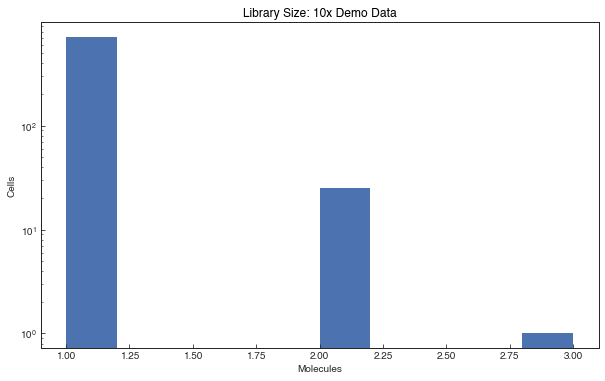

In [7]:
# library sizes
fig2, ax2 = plt.subplots(figsize=(10, 6))
library_size = df.sum(axis=1)
ax2.hist(library_size, log=True);
ax2.set_title('Library Size: 10x Demo Data')
ax2.set_xlabel('Molecules')
ax2.set_ylabel('Cells')

Principal component analysis is a great way to collapse multiple sparse features into a smaller number of covarying vectors. In the case of the demo data, we only have ~700 molecules, so we need to use this to get something plottable. In a normal dataset, running PCA would show you the major trends in the data. Common features represented by PCs include biological factors such as response to an experimental stimulus, cell cycle stage, or separation of different cell types. Technical features such as cell size or batch effects are often also captured by principal component analysis. 

Below, the cells have been colored by their molecule number (library size), displaying how the cells with more molecules receive more extreme principal component loadings.

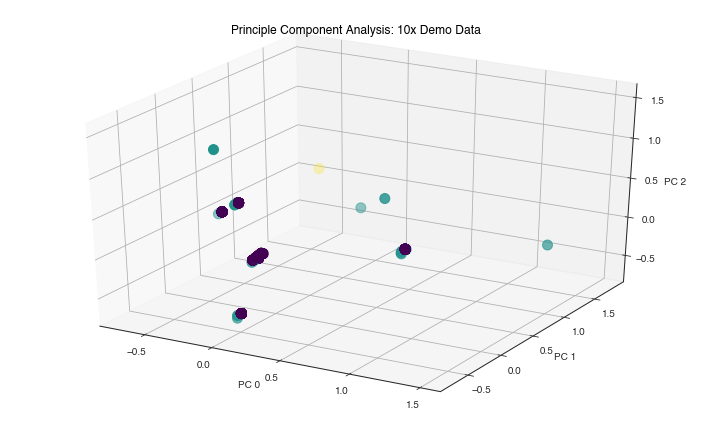

In [8]:
# run PCA, retaining only 3 dimensions; we don't have much data, no real point in taking more. 
pca = PCA(n_components=3)
dim_reduced = pca.fit_transform(df.values.astype(float))

# plot principle components, color by library size
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dim_reduced[:, 0], dim_reduced[:, 1], dim_reduced[:, 2], c=df.sum(axis=1), cmap=plt.cm.viridis, s=100)
ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 2')
ax.set_title('Principle Component Analysis: 10x Demo Data')
plt.tight_layout()

Clustering can provide some insight into which cells share biological or technical features. Hierarchical clustering is a method commonly applied to the cell covariance matrix, a matrix that measures how similar each cell's expression is to all other cells. 

Below, we can see that there are two groups of cells (bottom right) with moderate covariance

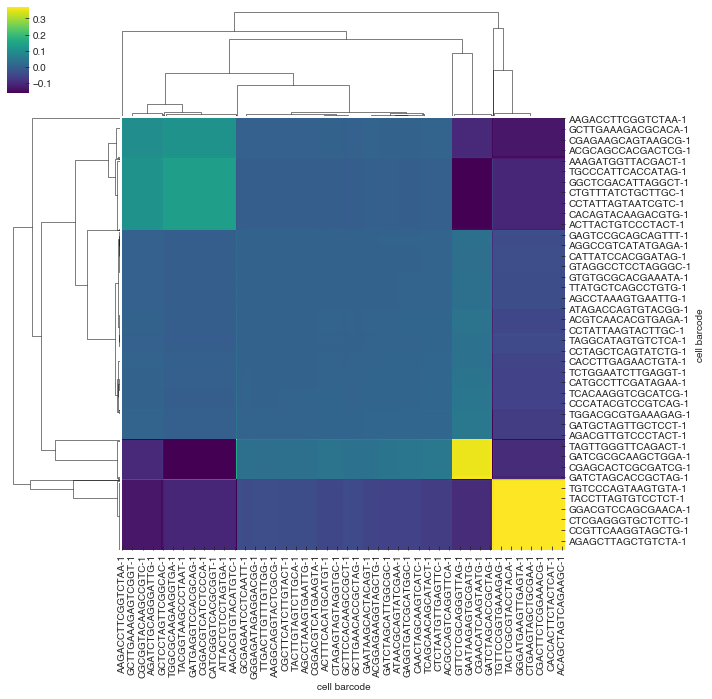

In [9]:
# run hierarchical clustering on the test dataset, 
cell_covariance = pd.DataFrame(dim_reduced, index=df.index).T.cov()
cm = sns.clustermap(cell_covariance, cmap=plt.cm.viridis, robust=True)

We can redo this analysis on the genes instead by running PCA on the transposed matrix. This shows that we have very little signal in the data, as only two of the genes have any covariance at all!

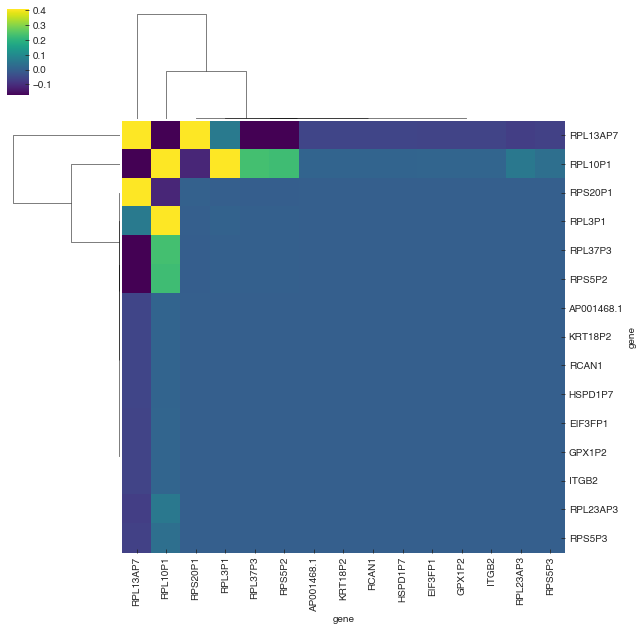

In [10]:
# run PCA, retaining only 3 dimensions; we don't have much data, no real point in taking more. 
pca = PCA(n_components=3)
gene_dim_reduced = pca.fit_transform(df.T.values.astype(float))
gene_covariance = pd.DataFrame(gene_dim_reduced, index=df.columns).T.cov() 
high_signal_genes = gene_covariance.sum(axis=1).sort_values(ascending=False)[:15].index
cm = sns.clustermap(gene_covariance.loc[high_signal_genes, high_signal_genes], robust=True, cmap=plt.cm.viridis)